# Reconstructed cell neurite lengths
Plotting both (1) path length distances to the leaves of the skeletons and (2) the dendritic lengths reconstructed as a percentage of the expected value.

In [1]:
import numpy as np
import pandas as pd
import random
from scipy import stats

from matplotlib import rcParams as rc
from matplotlib import pyplot as plt

from lib import plot, u

In [2]:
rc.update({'font.size': 20})

## Reading data

In [3]:
pyr_leaves_raw = pd.read_csv('data/pyr_dist_to_leaves.csv', index_col=0)
inh_leaves = pd.read_csv('data/inh_dist_to_leaves.csv', index_col=0)

In [4]:
pyr_complengths_raw = pd.read_csv('data/pyr_compartment_lengths.csv', index_col=0)

In [5]:
pyrs_clean_compartments = u.read_ids("data/clean_compartment_ids_v185.csv")

In [6]:
pyr_leaves = pyr_leaves_raw[pyr_leaves_raw.pt_root_id.isin(pyrs_clean_compartments)]
pyr_complengths = pyr_complengths_raw[
    pyr_complengths_raw.cellid.isin(pyrs_clean_compartments)].copy()

In [7]:
pyr_leaves.head()

,cell_type,pt_position,pt_root_id,axon_lengths_um,apical_dend_lengths_um,basal_dend_lengths_um,ambiguous_dend_lengths_um
4,e,[58128 35616 2059],648518346349522862,[],[],"[91.20472022544963, 102.88734776143033]",[]
12,e,[110640 78688 1695],648518346349523129,[],"[131.2452921728129, 150.3057287391294, 101.106...","[136.5257909077327, 102.37174734038567, 70.222...",[]
13,e,[43968 72624 1439],648518346349533252,[],[141.5853759287662],"[22.856089731621978, 27.67764911144163, 27.846...",[]
16,e,[72752 75248 738],648518346349538001,[],"[122.11307305051292, 67.94374741712075, 50.608...",[],[]
17,e,[103552 58464 1209],648518346349539414,[63.38938742297293],"[137.73413715539783, 123.33671664010535, 68.48...","[120.72781418028211, 121.05745452866927, 93.96...",[]


In [8]:
inh_leaves.head()

,cell_type,pt_position,pt_root_id,axon_lengths_um,dendrite_lengths_um,cell_subtype
0,i,[86768 55856 1230],648518346349528994,"[261.65309749276224, 258.4801296853987, 295.50...","[42.31827488625724, 73.69974670903073, 103.816...",basket
1,i,[104432 58272 821],648518346349489861,[50.789981481195696],"[122.86438628850311, 80.88754725911664, 80.590...",bipolar
2,i,[99984 54144 2124],648518346349522740,[],"[193.02834511189195, 186.73636736860374, 94.99...",unknown_type
3,i,[72384 51808 889],648518346349538285,"[170.4840290226951, 125.36081407085878, 101.32...","[153.8435688301389, 115.4814931272232, 105.706...",bipolar
4,i,[73584 60096 990],648518346349487752,[41.10914797728458],"[61.85844933732447, 51.70699369574795, 53.2648...",bipolar


In [9]:
pyr_complengths.head()

,cellid,soma_length_um,axon_length_um,basal_length_um,apical_length_um,ambiguous dendrite_length_um,ambiguous_length_um
4,648518346349522862,15.009022,0.000000,192.778053,0.000000,0.0,0.0
12,648518346349523129,37.956093,0.000000,327.055188,567.679268,0.0,0.0
13,648518346349533252,64.470290,0.000000,351.839554,141.306714,0.0,0.0
16,648518346349538001,27.844939,0.000000,0.000000,885.007456,0.0,0.0
17,648518346349539414,143.935690,63.255578,1384.713261,543.477423,0.0,0.0


## Formatting data

In [10]:
def length_frame(df, lengthcol, celltype, neuritetype):
    cellids, lengths, celltypes, neuritetypes = [], [], [], []
    
    for (cellid, lens) in zip(df["pt_root_id"], df[lengthcol]):
        for length in eval(lens):
            cellids.append(cellid)
            lengths.append(length)
            celltypes.append(celltype)
            neuritetypes.append(neuritetype)
    
    data_dict = {
        "cellid": pd.Series(cellids, dtype="int"),
        "neuritelength": lengths,
        "celltype": celltypes,
        "neuritetype": neuritetypes
    }

    return pd.DataFrame(data_dict)


def assemble_pyr_data(df):
    axondf = length_frame(df, "axon_lengths_um", "pyramidal", "axon")
    basaldf = length_frame(df, "basal_dend_lengths_um", "pyramidal", "basal")
    apicaldf = length_frame(df, "apical_dend_lengths_um", "pyramidal", "apical")
    
    return pd.concat((axondf, basaldf, apicaldf), ignore_index=True)


def assemble_inh_data(df):
    typedfs = []
    for (typename, subdf) in df.groupby("cell_subtype"):
        typedfs.append(assemble_typedf(subdf, typename))
    
    return pd.concat(typedfs, ignore_index=True)


def assemble_typedf(df, celltype):
    neuritedfs = []
    axondf = length_frame(df, "axon_lengths_um", celltype, "axon")
    denddf = length_frame(df, "dendrite_lengths_um", celltype, "dendrite")
    
    return pd.concat((axondf, denddf), ignore_index=True)


def assemble_all_data():
    pyrdf = assemble_pyr_data(pyr_leaves)
    inhdf = assemble_inh_data(inh_leaves)
    
    return pd.concat((pyrdf, inhdf), ignore_index=True)

In [11]:
leafdata = assemble_all_data()

In [12]:
leafdata.head()

,cellid,neuritelength,celltype,neuritetype
0,648518346349539414,63.389387,pyramidal,axon
1,648518346349539068,170.201125,pyramidal,axon
2,648518346349539068,198.988961,pyramidal,axon
3,648518346349539068,131.830306,pyramidal,axon
4,648518346349539068,145.062587,pyramidal,axon


In [13]:
leafdata.loc[leafdata.celltype == "unknown_type", "celltype"] = "unclassified"

In [14]:
plotdf = leafdata.groupby(["cellid", "celltype", "neuritetype"])["neuritelength"].\
    quantile([0.05, 0.5, 0.95]).unstack().reset_index()

In [15]:
plotdf.head()

,cellid,celltype,neuritetype,0.05,0.5,0.95
0,648518346349477331,bipolar,axon,66.320367,182.381953,321.115928
1,648518346349477331,bipolar,dendrite,14.907629,41.191849,115.981463
2,648518346349487432,bipolar,dendrite,5.608375,50.099377,106.246134
3,648518346349487752,bipolar,axon,41.109148,41.109148,41.109148
4,648518346349487752,bipolar,dendrite,14.267682,59.603715,134.409277


In [16]:
plotdf["celltype"] = [c.capitalize() for c in plotdf.celltype]

## Plotting

#### Distances to leaves (neurite length from soma)

In [17]:
def _errorbar_w_jitter(xs, ys, errslow, errshi,
                      jitter=0.2, seed=None, **kwargs):
    if seed is not None:
        np.random.seed(seed)

    xs = xs + stats.uniform(-jitter, 2*jitter).rvs(len(xs))
    low = ys - errslow
    hi = errshi - ys
    
    plt.errorbar(xs, ys, yerr=[low, hi],
                 marker='', linestyle='', color="tab:gray")
    plt.scatter(xs, ys, marker='o', s=20, color='k', zorder=10)
    

def errorbar_w_jitter(df, levels, levelcolname="celltype",
                      seed=None, level_xs=None):
    df = df[df[levelcolname].isin(levels)]
    
    if level_xs is None:
        level_xs = list(range(len(levels)))

    levelmap = {level: x for (level, x) in zip(levels, level_xs)}
    xs = [levelmap[v] for v in df[levelcolname]]
    
    _errorbar_w_jitter(xs, df[0.5], df[0.05], df[0.95], seed=seed)
    
    plt.xticks(level_xs, levels, rotation=45)

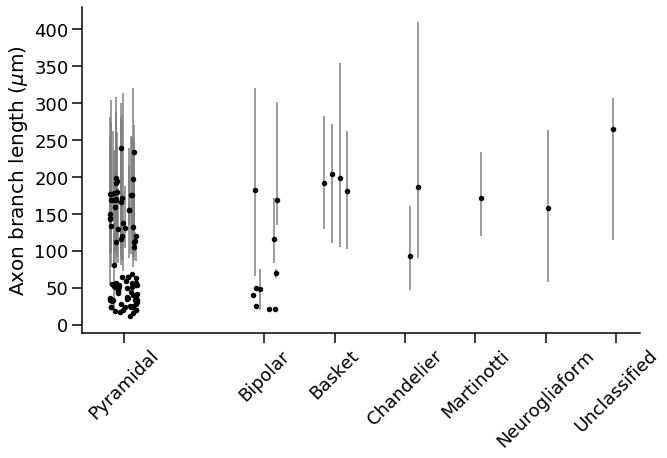

In [18]:
plt.figure(figsize=(10, 6))
levels = ["Pyramidal", "Bipolar", "Basket",
          "Chandelier", "Martinotti",
          "Neurogliaform", "Unclassified"]

errorbar_w_jitter(plotdf[plotdf.neuritetype == "axon"], levels,
                  level_xs = [0, 2, 3, 4, 5, 6, 7], seed=67234697)
plt.ylabel("Axon branch length ($\mu$m)")

plot.format_axes()
plt.show()

In [19]:
denddf = plotdf[plotdf.neuritetype != "axon"].copy()

full_neuritetype = []
for (celltype, neuritetype) in zip(denddf.celltype, denddf.neuritetype):
    if celltype != "Pyramidal":
        full_neuritetype.append(celltype)
    else:
        full_neuritetype.append(f"{celltype}\n{neuritetype}")

denddf.loc[:, "full_celltype"] = full_neuritetype

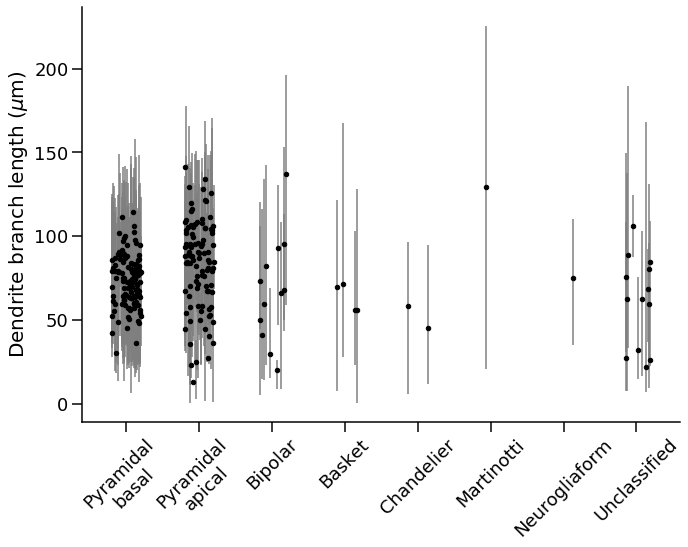

In [20]:
plt.figure(figsize=(10, 8))
levels = ["Pyramidal\nbasal", "Pyramidal\napical",
          "Bipolar", "Basket", "Chandelier", "Martinotti",
          "Neurogliaform", "Unclassified"]

errorbar_w_jitter(denddf, levels, levelcolname="full_celltype", seed=67234697)
plt.ylabel("Dendrite branch length ($\mu$m)")

plot.format_axes()
plt.tight_layout()
plt.savefig("assets/dendritelength.png")
plt.show()

### Percentage completion

In [21]:
pyr_complengths.head()

,cellid,soma_length_um,axon_length_um,basal_length_um,apical_length_um,ambiguous dendrite_length_um,ambiguous_length_um
4,648518346349522862,15.009022,0.000000,192.778053,0.000000,0.0,0.0
12,648518346349523129,37.956093,0.000000,327.055188,567.679268,0.0,0.0
13,648518346349533252,64.470290,0.000000,351.839554,141.306714,0.0,0.0
16,648518346349538001,27.844939,0.000000,0.000000,885.007456,0.0,0.0
17,648518346349539414,143.935690,63.255578,1384.713261,543.477423,0.0,0.0


In [22]:
pyr_complengths["dend_length_um"] = (
    pyr_complengths["apical_length_um"] +
    pyr_complengths["ambiguous dendrite_length_um"] +
    pyr_complengths["basal_length_um"])

In [23]:
def plotpercentagehist(data, bins):
    plt.hist(data, color='k', bins=bins)
    plt.xticks(np.arange(11) * 0.1, np.arange(11) * 10, fontsize=25)
    plt.yticks(fontsize=25)
    plt.xlim(0, 1)

Average path lengths from [Gilman, Medalla & Luebke 2017](https://doi.org/10.1093/cercor/bhw062):  

* Dendrite arbor - 4.291mm  
* Basal arbor - 2.583mm
* Apical arbor - 1.707mm

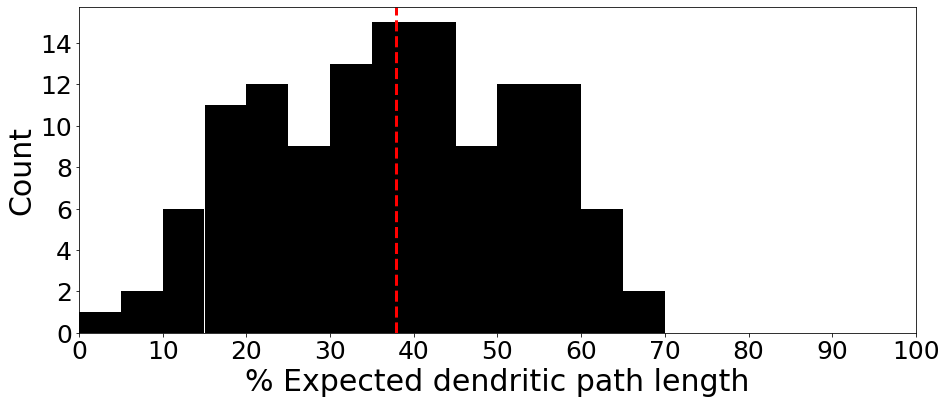

In [24]:
plt.figure(figsize=(15, 6))
  
bins = np.arange(21) * 0.05
percentages = pyr_complengths.dend_length_um / 4291
plotpercentagehist(percentages, bins)

plt.axvline(np.percentile(percentages, 50), ls='--', lw=3, color='r')

plt.xlabel("% Expected dendritic path length", fontsize=30)
plt.ylabel("Count", fontsize=30)

plt.show()

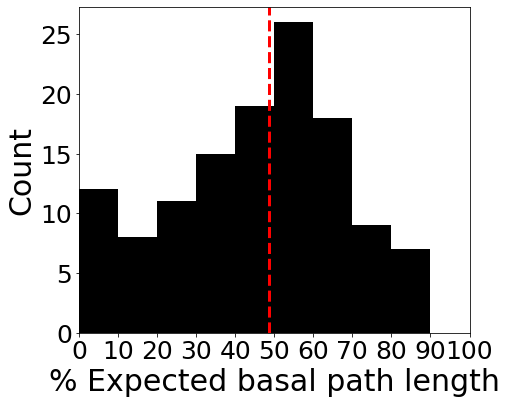

In [27]:
plt.figure(figsize=(7, 6))
  
bins = np.arange(11) * 0.1
percentages = pyr_complengths.basal_length_um / 2583
plotpercentagehist(percentages, bins)

plt.axvline(np.percentile(percentages, 50), ls='--', lw=3, color='r')

plt.xlabel("% Expected basal path length", fontsize=30)
plt.ylabel("Count", fontsize=30)

plt.show()

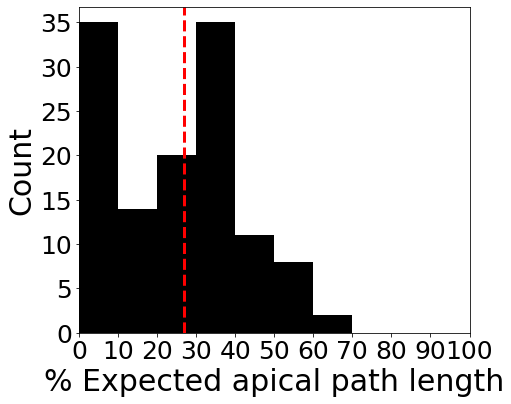

In [29]:
plt.figure(figsize=(7, 6))
  
bins = np.arange(11) * 0.1
percentages = pyr_complengths.apical_length_um / 1707
plotpercentagehist(percentages, bins)

plt.axvline(np.percentile(percentages, 50), ls='--', lw=3, color='r')

plt.xlabel("% Expected apical path length", fontsize=30)
plt.ylabel("Count", fontsize=30)

plt.show()